# Quantum Time Series Analysis: Analysis of SW QTSA Results
Compatible with Qiskit 1.2.4+

### Author
- October 2022: Prepared for Workshop on Quantum Machine Learning, 13 October 2022, organised in collaboration with QWorld, QPoland, QIndia and Quantum AI Foundation. In association with IEEE Conference Trends in Quantum Computing and Emerging Business Technologies - TQCEBT 2022
- May 2024: Compatibility upgrade to Qiskit 1.2.4+ 

### Aims
> *This script aims to analyse history of training an overloading quantum neural network with sliding-windows of time-series data.*

### Note
> *<font color="tomato">When running this script, you are likely to obtain slightly different results each time.</font>*

In [1]:
import sys
sys.path.append('.')
sys.path

['/home/jacob/miniconda3/envs/qiskit-gpu/lib/python311.zip',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.11',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.11/site-packages',
 '.']

In [2]:
import os
import numpy as np
import pylab
import math
import json
import time
from tqdm.notebook import tqdm

from IPython.display import clear_output

from utils.Target import *
from utils.Window import *
from utils.TS import *
from utils.Charts import *
from utils.Files import *
from utils.Cost import *
from utils.Metrics import *

import matplotlib.pyplot as plt
from matplotlib import set_loglevel
set_loglevel("error")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
### Libraries used in QTSA development

from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit_algorithms.optimizers import L_BFGS_B, P_BFGS, COBYLA, NELDER_MEAD, QNSPSA, ADAM, UMDA
from qiskit.circuit.library import RealAmplitudes, TwoLocal, ZFeatureMap, ZZFeatureMap,EfficientSU2, PauliFeatureMap
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit_algorithms.utils import algorithm_globals
from qiskit.visualization import plot_histogram, plot_state_city, plot_state_paulivec
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.utils.loss_functions import L1Loss, L2Loss
from qiskit.circuit import Parameter
from qiskit.compiler import transpile

from sklearn.metrics import r2_score, mean_absolute_percentage_error 

In [4]:
### Listing control
debug = True
seed = 2022

### Software version
MAJOR = 9
MINOR = 0

### Constants
LOG_NAME = 'log_2'
CASE_NAME = 'sliding'
DATA_NAME = '2_sins_sw'
DATA_PATH = f'{LOG_NAME}/data'
TRAIN_PATH = f'{LOG_NAME}/training'
PARAMS_PATH = f'{LOG_NAME}/params'
ANALYSIS_PATH = f'{LOG_NAME}/analysis'
FIGURES_PATH = f'{LOG_NAME}/figures'

### Show constants
(LOG_NAME, CASE_NAME, DATA_NAME,DATA_PATH, TRAIN_PATH, PARAMS_PATH, ANALYSIS_PATH, FIGURES_PATH)

('log_2',
 'sliding',
 '2_sins_sw',
 'log_2/data',
 'log_2/training',
 'log_2/params',
 'log_2/analysis',
 'log_2/figures')

## Fetch all source data
**<font color="red">Enter the name of the DATA_ID</font>**<br/>
*Note that this is windowed data (as indicated by "sw" in the data ID)*

In [5]:
### All created files have the following codes:
DATA_ID = '2_sins_sw_t50_v20_z0_w5_s1_h1'

### Define file names

x_all_fpath = f'{DATA_PATH}/{DATA_ID}/x_all.arr'
y_all_fpath = f'{DATA_PATH}/{DATA_ID}/y_all.arr'

x_train_ts_fpath = f'{DATA_PATH}/{DATA_ID}/x_train_ts.arr'
y_train_ts_fpath = f'{DATA_PATH}/{DATA_ID}/y_train_ts.arr'
x_valid_ts_fpath = f'{DATA_PATH}/{DATA_ID}/x_valid_ts.arr'
y_valid_ts_fpath = f'{DATA_PATH}/{DATA_ID}/y_valid_ts.arr'

data_info_fpath = f'{DATA_PATH}/{DATA_ID}/info.json'
data_info_fpath

'log_2/data/2_sins_sw_t50_v20_z0_w5_s1_h1/info.json'

In [6]:
### Load the info file
data_info = read_json_file(data_info_fpath)
    
### Get info details
DATA_NAME = data_info['data_name']
DATA_MAJOR = data_info['major_version'] 
DATA_MINOR = data_info['minor_version']
samples_train = data_info['data_train']
samples_valid = data_info['data_valid']
noise = data_info['data_noise']
wind_size = data_info['wind_size']
wind_step = data_info['wind_step']
horizon = data_info['wind_horizon']
seed = data_info['seed']
samples = samples_train + samples_valid
train_pc = samples_train / samples

print(f'\nSaved time series info in file "{data_info_fpath}":\n')
for k in data_info.keys():
    print(f'\tinfo[{k}] = {data_info[k]}')
print()
print(f'\tcalc[samples] = {samples}')
print(f'\tcalc[train_pc] = {train_pc}')
print()


Saved time series info in file "log_2/data/2_sins_sw_t50_v20_z0_w5_s1_h1/info.json":

	info[data_name] = 2_sins_sw
	info[major_version] = 9
	info[minor_version] = 0
	info[data_train] = 50
	info[data_valid] = 20
	info[data_noise] = 0
	info[wind_size] = 5
	info[wind_step] = 1
	info[wind_horizon] = 1
	info[seed] = 2022

	calc[samples] = 70
	calc[train_pc] = 0.7142857142857143



In [7]:
### Load data files
X_all = read_ts_file(x_all_fpath)[..., None]
y_all = read_ts_file(y_all_fpath)
X_train_ts = read_ts_file(x_train_ts_fpath)
y_train_ts = read_ts_file(y_train_ts_fpath)[..., None]
X_valid_ts = read_ts_file(x_valid_ts_fpath)
y_valid_ts = read_ts_file(y_valid_ts_fpath)[..., None]
print(f'\nLoaded time series data\n')


Loaded time series data



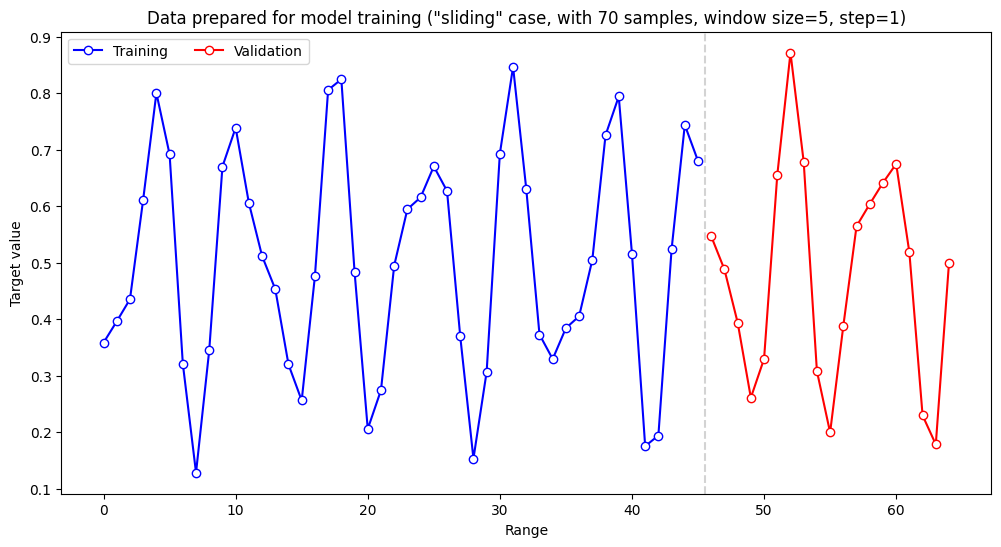

In [8]:
### Plot trainig and validation/test data partitions
#   Note that we will not use the X coordinates

y_train_flat_ts = ts_wind_flatten_avg(y_train_ts, wind_step)
y_valid_flat_ts = ts_wind_flatten_avg(y_valid_ts, wind_step)
y_list = [y_train_flat_ts, y_valid_flat_ts]
X_list = [0, len(y_train_flat_ts)]

print()
multi_plot_flat_ts(y_list, X_list=X_list, 
    colors = ['blue', 'red'], marker_colors=['white', 'white', 'lightblue', 'mistyrose'],
    labels = ['Training', 'Validation'], #ylim=(0.1, 1),
    lines = ['solid', 'solid'], markers = ['o', 'o'], legend_cols=2,
    title=f'Data prepared for model training ("{CASE_NAME}" case, with {samples} samples, window size={wind_size}, step={wind_step})')
print()

## Fetch all training meta-data
**<font color="red">Enter the name of the TRAIN_ID</font>**

In [9]:
### Training parameters

### All created files have the following codes:
#   n: sample size
#   z: level of noise injected
#   q: number of qubits
#   l: number of layers
#   opt_name: name of the optimiser
#   ep: number of "maxiter" epochs
TRAIN_ID = 'sliding_n70_z0_q3_xl2_il2_L_BFGS_B_ep60'
train_info_fpath = f'{TRAIN_PATH}/{TRAIN_ID}/info.json'
train_info_fpath

'log_2/training/sliding_n70_z0_q3_xl2_il2_L_BFGS_B_ep60/info.json'

In [10]:
## Fetch all training parameters
### Reading the info file
train_info = read_json_file(train_info_fpath)

print(f'\nLoaded time series from a file "{train_info_fpath}":\n')
for k in train_info.keys():
    print(f'\tinfo[{k}] = {train_info[k]}')
print()

### Get info details
CASE_NAME = train_info['case_name']
DATA_NAME = train_info['data_name']
MAJOR = train_info['major_version'] 
MINOR = train_info['minor_version']
samples = train_info['data_sample']
train_pc = train_info['data_split']
noise = train_info['data_noise']

qubits = train_info['ansatz_qubits']
inputs = train_info['ansatz_inputs']
xlayers = train_info['ansatz_xlayers']

il_start_idx = TRAIN_ID.find('_il')
il_start_str = TRAIN_ID[il_start_idx+3:]
il_end_idx = il_start_str.find('_')
il_str = il_start_str[:il_end_idx]
ilayers = int(il_str) # inferred, needs fixing
ent = 'circular' # assumed, needs fixing

log_interv = train_info['log_interv']
opt_name = train_info['opt_name']
epochs = train_info['epochs']
shots = train_info['shots']
seed = train_info['seed']

print(f'\tcalc[ansatz_ent] = {ent}')
print(f'\tcalc[ansatz_ilayers] = {ilayers}')
print()


Loaded time series from a file "log_2/training/sliding_n70_z0_q3_xl2_il2_L_BFGS_B_ep60/info.json":

	info[case_name] = sliding
	info[major_version] = 9
	info[minor_version] = 0
	info[data_name] = 2_sins_sw
	info[data_sample] = 70
	info[data_split] = 0.7142857142857143
	info[data_noise] = 0
	info[ansatz_qubits] = 3
	info[ansatz_inputs] = 5
	info[ansatz_xlayers] = 2
	info[log_interv] = 1
	info[opt_name] = L_BFGS_B
	info[epochs] = 60
	info[shots] = 10000
	info[seed] = 2022

	calc[ansatz_ent] = circular
	calc[ansatz_ilayers] = 2



## Fetch all training parameters and cost history

In [11]:
### Training info files 
init_fpath = f'{TRAIN_PATH}/{TRAIN_ID}/init.arr'
history_fpath = f'{TRAIN_PATH}/{TRAIN_ID}/hist.arr'
params_fpath = f'{PARAMS_PATH}/{TRAIN_ID}/params.arr'
train_info_fpath

'log_2/training/sliding_n70_z0_q3_xl2_il2_L_BFGS_B_ep60/info.json'

In [12]:
### Read training data
init_weights = read_ts_file(init_fpath)
objfun_vals = read_ts_file(history_fpath)
params_vals = read_ts_file(params_fpath)
print(f'Imported data shapes: init_weights={init_weights.shape}; '+\
      f'objfun_vals={objfun_vals.shape}; '+\
      f'params_vals={params_vals.shape}')

Imported data shapes: init_weights=(88,); objfun_vals=(68,); params_vals=(68, 88)


## Overloading Sliding Windows QTSA Qiskit Solution

### Identify device

In [13]:
### Find what devices are available
from qiskit_aer import Aer
from qiskit_aer.backends import AerSimulator
devices = AerSimulator().available_devices()
print(f'Available quantum devices: {devices}')

### Priority GPU
device = 'GPU' if ('GPU' in devices) else 'CPU'

### Force CPU for this run
device = 'CPU'
device
print(f'Selected device: {device}')

Available quantum devices: ('CPU', 'GPU')
Selected device: CPU


In [14]:
### Create a sampler/estimator suitable for the device
#   GPU methods: statevector, tensor_network, density_matrix, unitary

from qiskit.primitives import Sampler, Estimator # For "CPU", ignores device="GPU" option
from qiskit_aer.primitives import Sampler as AerSampler, Estimator as AerEstimator # For device="GPU" option

seed = 2022
shots = 10000

if device == 'GPU':
    sampler = AerSampler(
        backend_options={'seed_simulator': seed, 'method': 'statevector', 
                         'device' : device, 'cuStateVec_enable' : True},
        run_options={'seed': seed, 'shots': shots},
        transpile_options={'seed_transpiler': seed},
    )
    
    estimator = AerEstimator(
        backend_options={'seed_simulator': seed, 'method': 'statevector', 
                         'device' : device, 'cuStateVec_enable' : True},
        run_options={'seed': seed, 'shots': shots},
        transpile_options={'seed_transpiler': seed},
    )
else:
    sampler = Sampler()
    estimator = Estimator()

### Sliding window overloading QTSA circuit


Input params#: 15, Weight params#: 90, Layer#: x2 * i2 = 4



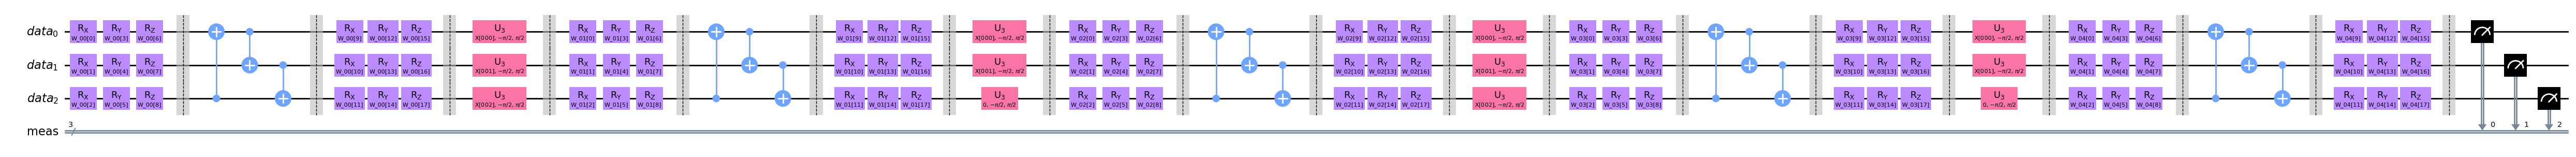

In [15]:
### Serial sliding window ansatz
#   - To be used with CircuitQNN / NeuralNetworkRegressor
#
#   inputs
#     qubit_no: The number of qubits in the circuit
#     input_no: The number of input values / the size of a sliding window
#     xlayers: The number of "external" ansatz layers
#     add_meas: If true measurements will be added
#     ent: Types of entanglements to be used
#
#   returns
#     Circuit: The serial sliding window ansatz 
#     SParams: The list of parameters used in all S blocks
#     WParams: The list of parameters used in all W blocks
#     Layers: The calculated number of "internal" layers in the circuit

def swindow_serial_model(qubit_no, input_no, xlayers=1, add_meas=False, ent='circular'):

    SLabel = 'X'
    WLabel = 'W'
    
    ilayers = input_no // qubit_no + (0 if input_no % qubit_no == 0 else 1)
    used_sgates = 0

    # Predefined all S parameters
    SParams = []
    for q in range(input_no):
        param_x = Parameter(f'{SLabel}[{q:03d}]')
        SParams.append(param_x)

    ### Create an ansatz
    qr = QuantumRegister(qubit_no, 'data')
    ansatz = QuantumCircuit(qr, name='ansatz')
    WParams = []

    # Data-encoding circuit block, packs different input vars
    def SN(qubit_no):
        nonlocal used_sgates, SParams
        s_qr = QuantumRegister(qubit_no)
        s_ansatz = QuantumCircuit(s_qr, name='SSM')
        for q in range(qubit_no):
            param_x = SParams[q] if used_sgates < input_no else 0
            s_ansatz.rx(param_x, q)
            used_sgates += 1
        return s_ansatz

    # Trainable circuit block
    def W(qubit_no, label):
        w_qr = QuantumRegister(qubit_no)
        w_ansatz = QuantumCircuit(w_qr, name='W')
        w_ansatz.append(
            TwoLocal(qubit_no, ['rx', 'ry', 'rz'], 'cx', 
                     entanglement=ent,
                     reps=1, 
                     parameter_prefix=label, 
                     insert_barriers=True,
                     skip_final_rotation_layer=False),
            qargs=w_qr)
        return w_ansatz

    used_wlayers = 0
    for xl in range(xlayers):
        used_sgates = 0
        
        for il in range(ilayers):
            W1 = W(qubit_no, f'W_{used_wlayers:02d}')
            used_wlayers += 1
            WParams = WParams + W1.parameters[:]
            ansatz.append(W1, qargs=qr)
            ansatz.barrier()
            SX = SN(qubit_no) # , 'X'+str(il))
            SParams = SParams + SX.parameters[:]
            ansatz.append(SX, qargs=qr)
            ansatz.barrier()
    
        if xl == xlayers-1:
            W1 = W(qubit_no, f'W_{used_wlayers:02d}')  
            used_wlayers += 1
            WParams = WParams + W1.parameters[:]
            ansatz.append(W1, qargs=qr)

    if add_meas:
        ansatz.measure_all()

    return ansatz.decompose().decompose().decompose(), SParams, WParams, ilayers

# Test a sample serial ansatz
test_qubits = 3; test_inputs= 5; test_xlayers = 2; test_ent = 'circular'
test_m, test_input_params, test_weight_params, test_ilayers = \
    swindow_serial_model(test_qubits, test_inputs, test_xlayers, ent=test_ent, add_meas=True)

# print(f'Layers: {ilayers}\nParams: {m.parameters}\n')
# print('Input params:\n', input_params)
# print('\nWeight params:\n', weight_params)
print(f'\nInput params#: {len(test_input_params)}, Weight params#: {len(test_weight_params)}, Layer#: x{test_xlayers} * i{test_ilayers} = {test_xlayers*test_ilayers}')

test_m.draw(output='mpl', style='clifford', fold=False, scale=1)
print()

## Analysis and reporting

In [16]:
### Reconstruct training prefix
ANALYSIS_PREF = TRAIN_ID

In [17]:
### Utility

# Define output interpretations (sampler)
output_shape = 2
parity = lambda x: "{:b}".format(x).count("1") % 2
first_only = lambda x: x % 2
identity_interpret = lambda x: x

# Define observables (estimator)
op = SparsePauliOp.from_list([("Z" * qubits, 1)]) 
op1 = SparsePauliOp.from_list([("I" * qubits, 0.5), ("Z" * qubits, 0.5)])
op2 = SparsePauliOp.from_list([("I" * qubits, 0.5), ("Z" * qubits, -0.5)])

### Score the model

In [18]:
params_vals.shape

(68, 88)

### Score it properly

In [19]:
##### Calculate the score

### Init scores
train_mae_scores = []
train_mse_scores = []
train_r2_scores = []
test_mae_scores = []
test_mse_scores = []
test_r2_scores = []

### Score calculation and collection
start = time.time()
for param_no in tqdm(range(params_vals.shape[0])):
    
    # Define model, its parameters and their values
    model, input_params, weight_params, ilayers = swindow_serial_model(qubits, inputs, xlayers, ent=ent)
    sel_weights = params_vals[param_no]
    
    estim_qnn = EstimatorQNN(
        circuit=model,
        input_params=model.parameters[:inputs],
        weight_params=model.parameters[inputs:],
        observables=op, # [op1, op2],
        estimator=estimator
    )

    # Calculate results
    yp_train_true = y_train_ts
    yp_valid_true = y_valid_ts
    yp_train_hat = estim_qnn.forward(X_train_ts, sel_weights)
    yp_valid_hat = estim_qnn.forward(X_valid_ts, sel_weights)

    # Score results
    train_mae = mean_absolute_error(yp_train_true, yp_train_hat)
    train_mse = mean_squared_error(yp_train_true, yp_train_hat)
    train_r2 = r2_score(yp_train_true, yp_train_hat)
    test_mae = mean_absolute_error(yp_valid_true, yp_valid_hat)
    test_mse = mean_squared_error(yp_valid_true, yp_valid_hat)
    test_r2 = r2_score(yp_valid_true, yp_valid_hat)

    # Add scores to their lists
    train_mae_scores.append(train_mae)
    train_mse_scores.append(train_mse)
    train_r2_scores.append(train_r2)
    test_mae_scores.append(test_mae)
    test_mse_scores.append(test_mse)
    test_r2_scores.append(test_r2)

elapsed = time.time() - start
print()
print(f'\nThe number of processed parameters: {len(train_mae_scores)}, Time: {np.round(elapsed, 4)} secs\n')

  0%|          | 0/68 [00:00<?, ?it/s]



The number of processed parameters: 68, Time: 12.8849 secs



## Plot results

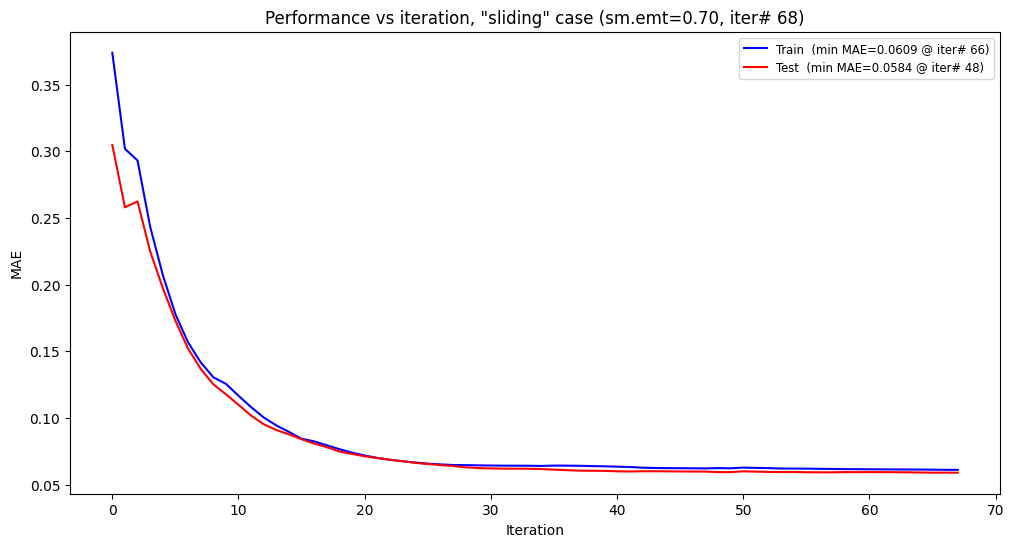

In [20]:
### Plot the MAE score
multi_perform_plot([train_mae_scores, test_mae_scores], log_interv=log_interv, 
    backplot=False, rcParams=(10, 6), dpi=100, smooth_weight=0.7, 
    title=f'Performance vs iteration, "{CASE_NAME}" case', meas_type='MAE', ylabel='MAE', xlabel='Iteration',
    meas_min=True, labels=['Train', 'Test'], line_styles=['solid', 'solid'], line_cols=['blue', 'red'], 
    save_plot=f'{FIGURES_PATH}/analz_{ANALYSIS_PREF}/mae_train_vs_test.eps')

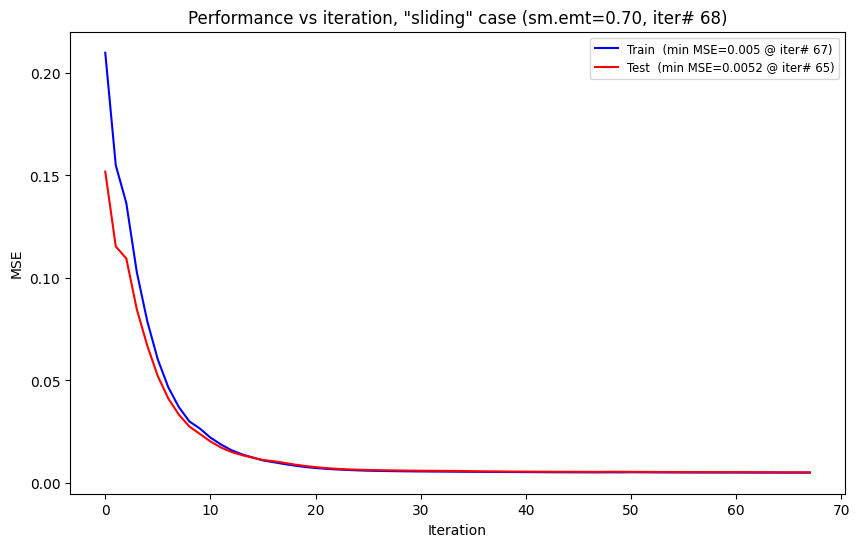

In [21]:
### Plot the MSE score
multi_perform_plot([train_mse_scores, test_mse_scores], log_interv=log_interv, 
    backplot=False, rcParams=(10, 6), dpi=100, smooth_weight=0.7, 
    title=f'Performance vs iteration, "{CASE_NAME}" case', meas_type='MSE', ylabel='MSE', xlabel='Iteration',
    meas_min=True, labels=['Train', 'Test'], line_styles=['solid', 'solid'], line_cols=['blue', 'red'], 
    save_plot=f'{FIGURES_PATH}/analz_{ANALYSIS_PREF}/mse_train_vs_test.eps')

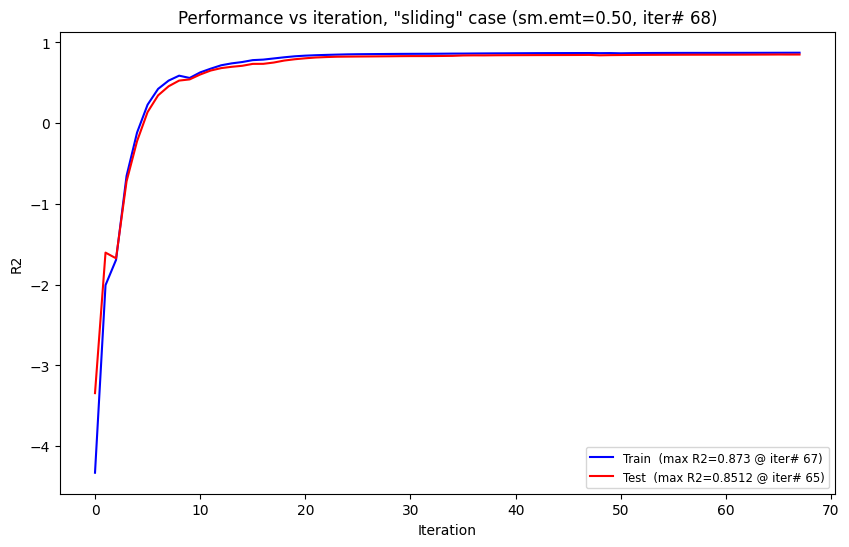

In [22]:
### Plot the R2 score
multi_perform_plot([train_r2_scores, test_r2_scores], log_interv=log_interv, 
    backplot=False, rcParams=(10, 6), dpi=100, smooth_weight=0.5, 
    title=f'Performance vs iteration, "{CASE_NAME}" case', meas_type='R2', ylabel='R2', xlabel='Iteration',
    meas_min=False, labels=['Train', 'Test'], line_styles=['solid', 'solid'], line_cols=['blue', 'red'], 
    save_plot=f'{FIGURES_PATH}/analz_{ANALYSIS_PREF}/r2_train_vs_test.eps')

In [23]:
##### Plot selected fit
sel_params_no = 65 // log_interv

### Define model, its parameters and their values
model, input_params, weight_params, ilayers = swindow_serial_model(qubits, inputs, xlayers, ent=ent)
sel_weights = params_vals[param_no]

sel_qnn = EstimatorQNN(
    circuit=model,
    input_params=model.parameters[:inputs],
    weight_params=model.parameters[inputs:],
    observables=op, # [op1, op2],
    estimator=estimator
)

### Calculate results
start = time.time()

yp_train_true = y_train_ts
yp_valid_true = y_valid_ts
yp_train_hat = sel_qnn.forward(X_train_ts, sel_weights)
yp_valid_hat = sel_qnn.forward(X_valid_ts, sel_weights)

elapsed = time.time() - start

### Score results
train_r2 = np.round(r2_score(yp_train_true, yp_train_hat), 4)
train_mse = np.round(mean_squared_error(yp_train_true, yp_train_hat), 4)
test_r2 = np.round(r2_score(yp_valid_true, yp_valid_hat), 4)
test_mse = np.round(mean_squared_error(yp_valid_true, yp_valid_hat), 4)

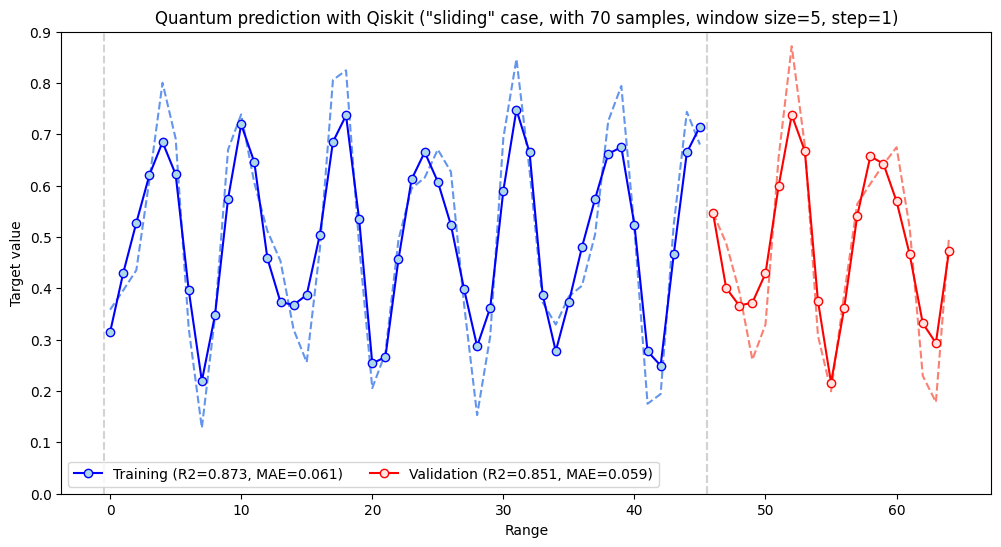

In [24]:
### Plot trainig and validation/test data partitions
#   Note that we will not use the X coordinates

y_train_flat_ts = ts_wind_flatten_avg(y_train_ts, wind_step)
y_train_hat_flat_ts = ts_wind_flatten_avg(yp_train_hat.reshape(y_train_ts.shape), wind_step)
y_valid_flat_ts = ts_wind_flatten_avg(y_valid_ts, wind_step)
y_valid_hat_flat_ts = ts_wind_flatten_avg(yp_valid_hat.reshape(y_valid_ts.shape), wind_step)

y_list = [y_train_flat_ts, y_valid_flat_ts, y_train_hat_flat_ts, y_valid_hat_flat_ts]
X_list = [0, len(y_train_flat_ts), 0, len(y_train_flat_ts)]

print()
multi_plot_flat_ts(y_list, X_list=X_list, legend_cols=2, ylim=(0, 0.9),
    colors = ['cornflowerblue', 'salmon', 'blue', 'red'], 
    marker_colors=['white', 'white', 'lightblue', 'mistyrose'],
    labels=['', '', f'Training (R2={np.round(train_r2, 3)}, MAE={np.round(train_mae, 3)})', f'Validation (R2={np.round(test_r2, 3)}, MAE={np.round(test_mae, 3)})'],
    lines = ['dashed', 'dashed', 'solid', 'solid'], 
    markers = ['none', 'none', 'o', 'o'],
    title=f'Quantum prediction with Qiskit ("{CASE_NAME}" case, with {samples} samples, window size={wind_size}, step={wind_step})',
    save_plot=f'{FIGURES_PATH}/analz_{ANALYSIS_PREF}/qiskit_fit_{sel_params_no*log_interv:03}.eps'
)
print()

## Save analysis data

In [25]:
### Training info files 
train_mae_scores_fpath = f'{ANALYSIS_PATH}/{ANALYSIS_PREF}/train_mae_scores.arr'
train_mse_scores_fpath = f'{ANALYSIS_PATH}/{ANALYSIS_PREF}/train_mse_scores.arr'
train_r2_scores_fpath = f'{ANALYSIS_PATH}/{ANALYSIS_PREF}/train_r2_scores.arr'
test_mae_scores_fpath = f'{ANALYSIS_PATH}/{ANALYSIS_PREF}/test_mae_scores.arr'
test_mse_scores_fpath = f'{ANALYSIS_PATH}/{ANALYSIS_PREF}/test_mse_scores.arr'
test_r2_scores_fpath = f'{ANALYSIS_PATH}/{ANALYSIS_PREF}/test_r2_scores.arr'
train_mae_scores_fpath

'log_2/analysis/sliding_n70_z0_q3_xl2_il2_L_BFGS_B_ep60/train_mae_scores.arr'

In [26]:
### Save the scores
write_ts_file(train_mae_scores_fpath, train_mae_scores)
write_ts_file(train_mse_scores_fpath, train_mse_scores)
write_ts_file(train_r2_scores_fpath, train_r2_scores)
write_ts_file(test_mae_scores_fpath, test_mae_scores)
write_ts_file(test_mse_scores_fpath, test_mse_scores)
write_ts_file(test_r2_scores_fpath, test_r2_scores)
print(f'Saved model scores')

Saved model scores


## System

In [27]:
!pip list | grep -e qiskit -e torch

qiskit                    1.2.4
qiskit-aer-gpu            0.15.1
qiskit-algorithms         0.3.1
qiskit-ibm-runtime        0.32.0
qiskit-machine-learning   0.7.2
qiskit-optimization       0.6.1
